### Required Libs


In [2]:
"""
    File name: Plot_Utils.ipynb
    Author: Amin Abyaneh
    Email: aminabyaneh@gmail.com
    Date created: 25/04/2021
    Python Version: 3.8
    Description: Extracting the execution data by plots.
"""

# ========================================================================
# Copyright 2021, The CFL Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# You may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================


import os, sys
import pickle
import networkx as nx
from typing import List, Dict

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

def retrieve_client_info(stored_results_dict, metric='SHD', client_id='priors') -> np.ndarray:
    """ Return client results for a specific client id.
    
    Note: default is to return information for prior, or the end of the round results.
    """
    return np.asarray([np.array(client_dict[metric], dtype=np.int32) for client_dict in stored_results_dict[client_id]])

def retrieve_adj_mats_per_round(stored_results_dict: Dict, rounds: List, client_id=-1) -> np.ndarray:
    """Return a list of adjacency matrices for a list of round ids.
    
    Note: default for client_id is -1 so that the method returns the aggregated adj mat at the end of each round,
    could be modified to client_id = {1.. num_clients} for retrieveing each client's adj matrix.
    """
    return [np.asarray(stored_results_dict['matrices'][round_id][client_id]) for round_id in rounds]


### Unbalanced Interventions locality method search for alpha



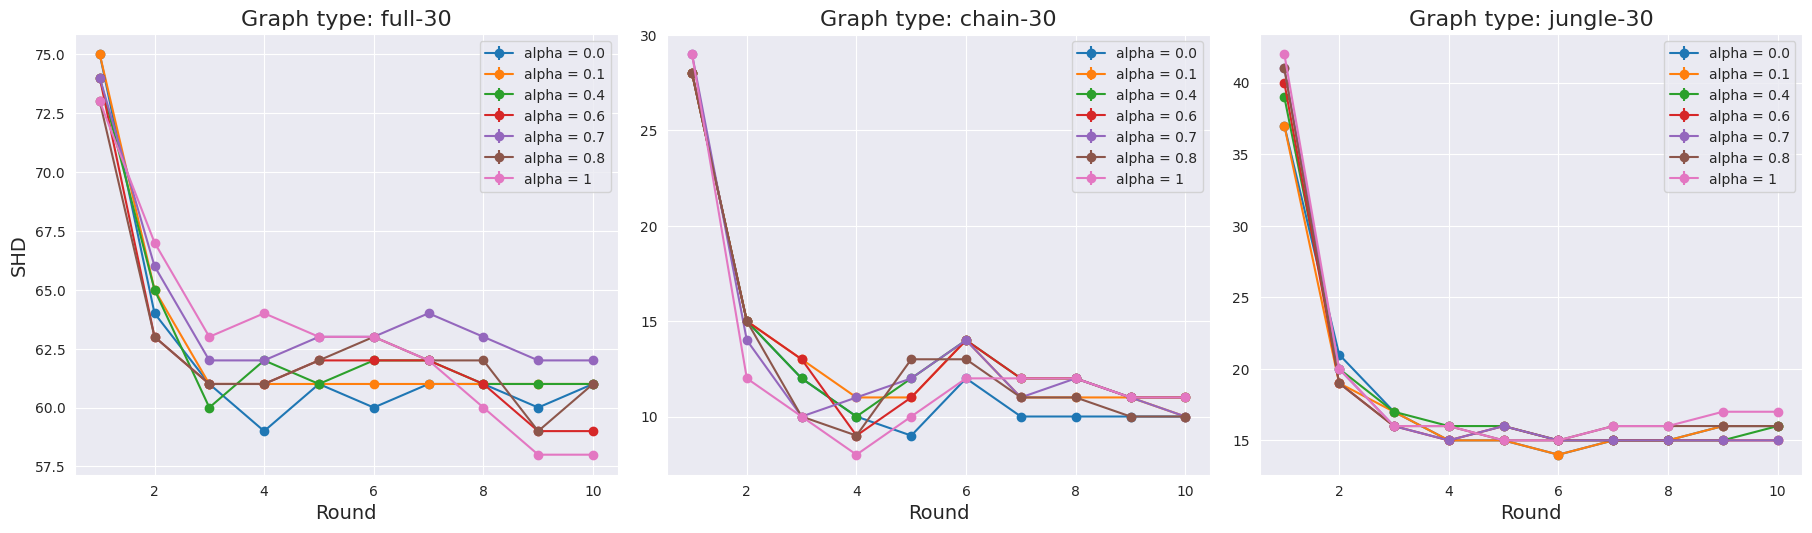

In [7]:
# General Setup
num_experiments, num_rounds, repeat_count, plot_metric, std_exageration = 3, 10, 5, "SHD", 1
num_vars = 20

# Specific Setup
experiment_graphs = "rnd"
splits = [(10, 90)]

# Graphs
graph_types = ["chain", "jungle", "full", "collider", "bidiag"]  
edge_probs = [0.2, 0.4, 0.6, 0.8, 1.0]
alphas = [0.1, 0.3, 0.5, 0.7]

# Build experiments info
graphs = graph_types if experiment_graphs == "str" else edge_probs
title = "Graph type: " if experiment_graphs == "str" else "Edge prob.: "

intervention_labels = list()
for split in splits:
    intervention_labels.append([f'Single Client 0 {int((split[0] / 100) * num_vars)}-vars', 
                                f'Single Client 1 {int((split[1] / 100) * num_vars)}-vars', 
                                "Federated Setup"])

parent_folder_name = 'alpha_search/rnd_search'
specifiers = alphas

colors = ["blue", "orange", "green"]
rounds = np.arange(start=1, stop=num_rounds + 1, step=1)

n_row = len(specifiers)
n_col = len(graphs)

sns.set_style("whitegrid", {
    "xtick.major.size": 0.1,
    "ytick.major.size": 0.1,
    'grid.linestyle': '--'
 })

sns.despine()

fig, axs = plt.subplots(n_row, n_col, figsize=(32, 18), dpi=100)
fig.tight_layout(h_pad=2, w_pad=1.5)

for row, specifier in enumerate(specifiers):
    for col, graph in enumerate(graphs):
        axs[row, col].set_title(f'{title}{graph}, alpha={specifier}', fontsize=16)
        folder_name = f'ToySetup-{graph}-{num_vars}-alpha-aps-10-90-{specifier}'

        for experiment_id in range(num_experiments):
            metrics = list()
            for rep_idx in range(repeat_count):
                data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
                load_dir = os.path.join('data', parent_folder_name, folder_name, data_file_name)

                with open(load_dir, 'rb') as handle:
                    results_dict = pickle.load(handle)

                metrics.append(retrieve_client_info(results_dict, plot_metric, client_id='round_metrics'))

            metrics_avg = np.mean(np.asarray(metrics), axis=0)
            metrics_std = np.std(np.asarray(metrics), axis=0)

            lab = f'{intervention_labels[0][experiment_id]}'
            axs[row, col].plot(rounds, metrics_avg, label=lab, linestyle='solid', marker='o')
            axs[row, col].fill_between(rounds, metrics_avg - std_exageration * metrics_std,
                                      (metrics_avg + std_exageration * metrics_std),
                                       alpha=0.1)

            axs[row, col].legend(loc='best')

            axs[row, col].set_ylabel(plot_metric, fontsize=14)
            axs[n_row - 1, col].set_xlabel('Round', fontsize=14)
            axs[row, col].set_xlim([0.5, 10.5])
            
            start, end = axs[row, col].get_ylim()
            axs[row, col].yaxis.set_ticks(np.arange(0, end, 5).astype(int))
            axs[row, col].xaxis.set_ticks(np.arange(1, 11, 1).astype(int))

    plt.savefig(f'int-asym-c{num_clients}-v{num_vars}-g{graph_types}.png', bbox_inches='tight')
plt.show()


### Toy experiments with structured and random graphs

<Figure size 432x288 with 0 Axes>

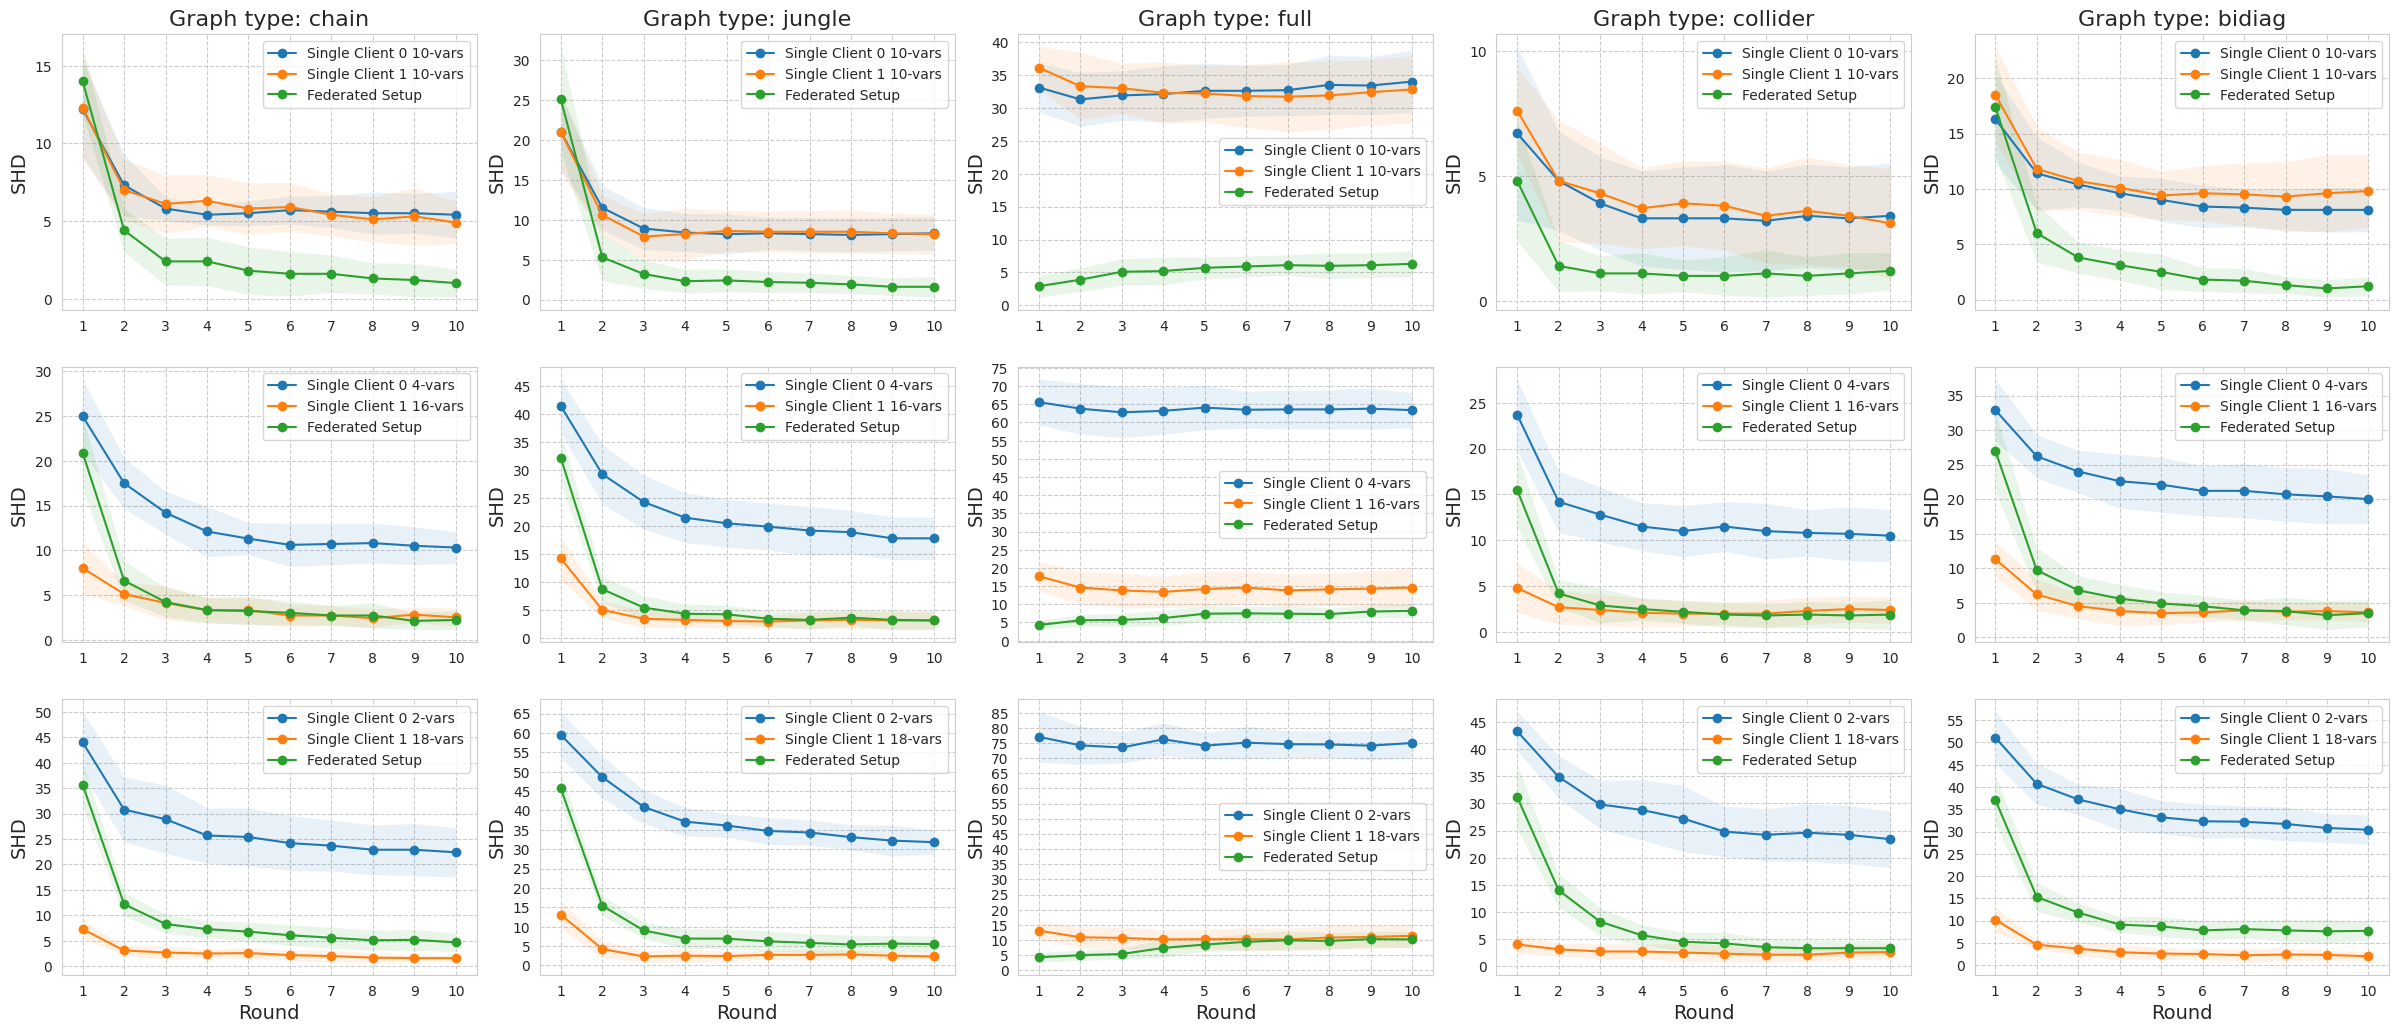

In [15]:
# General Setup
num_experiments, num_rounds, repeat_count, plot_metric, std_exageration = 3, 10, 10, "SHD", 1
num_vars = 20

# Specific Setup
experiment_graphs = "str"
splits = [(50, 50), (20, 80), (10, 90)]

# Graphs
graph_types = ["chain", "jungle", "full", "collider", "bidiag"]  
edge_probs = [0.2, 0.4, 0.6, 0.8, 1.0]

# Build experiments info
graphs = graph_types if experiment_graphs == "str" else edge_probs
title = "Graph type: " if experiment_graphs == "str" else "Edge prob.: "

intervention_labels = list()
for split in splits:
    intervention_labels.append([f'Single Client 0 {int((split[0] / 100) * num_vars)}-vars', 
                                f'Single Client 1 {int((split[1] / 100) * num_vars)}-vars', 
                                "Federated Setup"])

parent_folder_name = f'{experiment_graphs}_toy'
specifiers = [f'aps-{split[0]}-{split[1]}' for split in splits]

colors = ["blue", "orange", "green"]
rounds = np.arange(start=1, stop=num_rounds + 1, step=1)

n_row = len(splits)
n_col = len(graphs)

sns.set_style("whitegrid", {
    "xtick.major.size": 0.1,
    "ytick.major.size": 0.1,
    'grid.linestyle': '--'
 })

sns.despine()

fig, axs = plt.subplots(n_row, n_col, figsize=(24, 10), dpi=100)
fig.tight_layout(h_pad=2, w_pad=1.5)

for row, specifier in enumerate(specifiers):
    for col, graph in enumerate(graphs):
        axs[0, col].set_title(f'{title}{graph}', fontsize=16)
        folder_name = f'ToySetup-{graph}-{num_vars}-{specifier}'

        for experiment_id in range(num_experiments):
            metrics = list()
            for rep_idx in range(repeat_count):
                data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
                load_dir = os.path.join('data', parent_folder_name, folder_name, data_file_name)

                with open(load_dir, 'rb') as handle:
                    results_dict = pickle.load(handle)

                metrics.append(retrieve_client_info(results_dict, plot_metric, client_id='round_acycle_metrics'))

            metrics_avg = np.mean(np.asarray(metrics), axis=0)
            metrics_std = np.std(np.asarray(metrics), axis=0)

            lab = f'{intervention_labels[row][experiment_id]}'
            axs[row, col].plot(rounds, metrics_avg, label=lab, linestyle='solid', marker='o')
            axs[row, col].fill_between(rounds, metrics_avg - std_exageration * metrics_std,
                                      (metrics_avg + std_exageration * metrics_std),
                                       alpha=0.1)

            axs[row, col].legend(loc='best')

            axs[row, col].set_ylabel(plot_metric, fontsize=14)
            axs[n_row - 1, col].set_xlabel('Round', fontsize=14)
            axs[row, col].set_xlim([0.5, 10.5])
            
            start, end = axs[row, col].get_ylim()
            axs[row, col].yaxis.set_ticks(np.arange(0, end, 5).astype(int))
            axs[row, col].xaxis.set_ticks(np.arange(1, 11, 1).astype(int))

    # plt.savefig(f'int-asym-c{num_clients}-v{num_vars}-g{graph_types}.png', bbox_inches='tight')
plt.show()


### Solve 10-90 problem



<Figure size 432x288 with 0 Axes>

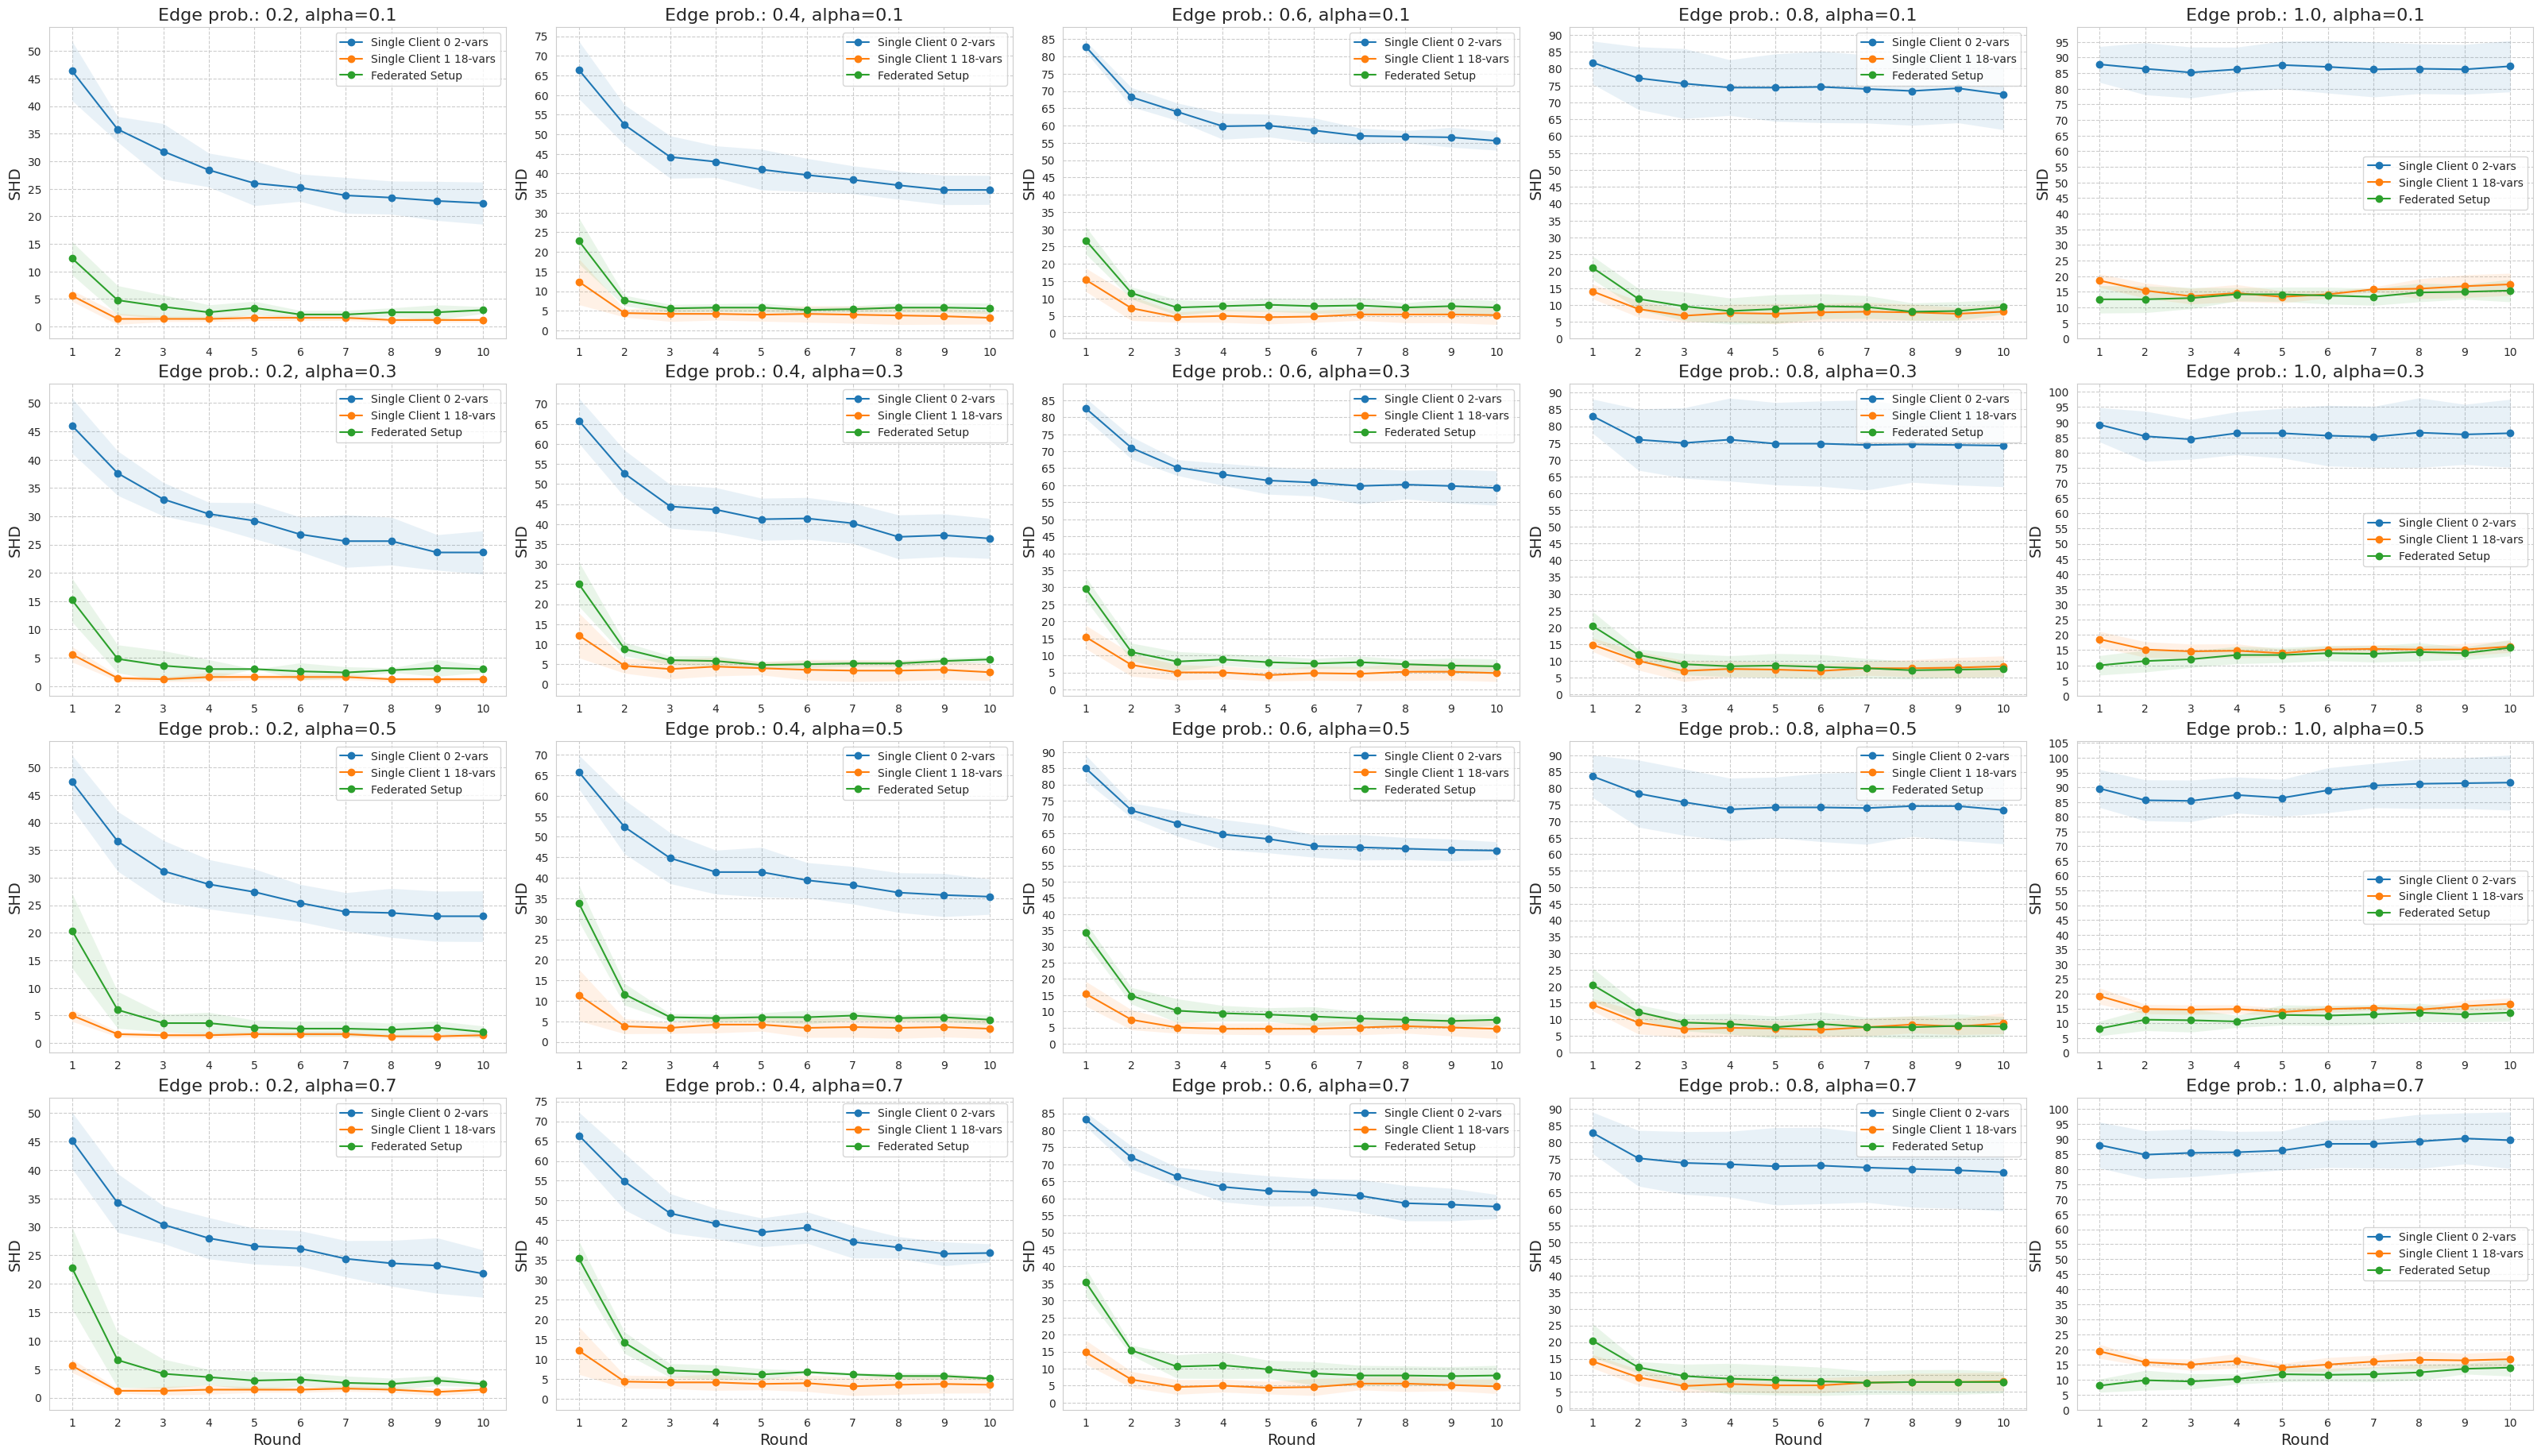

In [12]:
# General Setup
num_experiments, num_rounds, repeat_count, plot_metric, std_exageration = 3, 10, 5, "SHD", 1
num_vars = 20

# Specific Setup
experiment_graphs = "rnd"
splits = [(10, 90)]

# Graphs
graph_types = ["chain", "jungle", "full", "collider", "bidiag"]  
edge_probs = [0.2, 0.4, 0.6, 0.8, 1.0]
alphas = [0.1, 0.3, 0.5, 0.7]

# Build experiments info
graphs = graph_types if experiment_graphs == "str" else edge_probs
title = "Graph type: " if experiment_graphs == "str" else "Edge prob.: "

intervention_labels = list()
for split in splits:
    intervention_labels.append([f'Single Client 0 {int((split[0] / 100) * num_vars)}-vars', 
                                f'Single Client 1 {int((split[1] / 100) * num_vars)}-vars', 
                                "Federated Setup"])

parent_folder_name = 'alpha_search/rnd_search'
specifiers = alphas

colors = ["blue", "orange", "green"]
rounds = np.arange(start=1, stop=num_rounds + 1, step=1)

n_row = len(specifiers)
n_col = len(graphs)

sns.set_style("whitegrid", {
    "xtick.major.size": 0.1,
    "ytick.major.size": 0.1,
    'grid.linestyle': '--'
 })

sns.despine()

fig, axs = plt.subplots(n_row, n_col, figsize=(32, 18), dpi=100)
fig.tight_layout(h_pad=2, w_pad=1.5)

for row, specifier in enumerate(specifiers):
    for col, graph in enumerate(graphs):
        axs[row, col].set_title(f'{title}{graph}, alpha={specifier}', fontsize=16)
        folder_name = f'ToySetup-{graph}-{num_vars}-alpha-aps-10-90-{specifier}'

        for experiment_id in range(num_experiments):
            metrics = list()
            for rep_idx in range(repeat_count):
                data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
                load_dir = os.path.join('data', parent_folder_name, folder_name, data_file_name)

                with open(load_dir, 'rb') as handle:
                    results_dict = pickle.load(handle)

                metrics.append(retrieve_client_info(results_dict, plot_metric, client_id='round_metrics'))

            metrics_avg = np.mean(np.asarray(metrics), axis=0)
            metrics_std = np.std(np.asarray(metrics), axis=0)

            lab = f'{intervention_labels[0][experiment_id]}'
            axs[row, col].plot(rounds, metrics_avg, label=lab, linestyle='solid', marker='o')
            axs[row, col].fill_between(rounds, metrics_avg - std_exageration * metrics_std,
                                      (metrics_avg + std_exageration * metrics_std),
                                       alpha=0.1)

            axs[row, col].legend(loc='best')

            axs[row, col].set_ylabel(plot_metric, fontsize=14)
            axs[n_row - 1, col].set_xlabel('Round', fontsize=14)
            axs[row, col].set_xlim([0.5, 10.5])
            
            start, end = axs[row, col].get_ylim()
            axs[row, col].yaxis.set_ticks(np.arange(0, end, 5).astype(int))
            axs[row, col].xaxis.set_ticks(np.arange(1, 11, 1).astype(int))

    # plt.savefig(f'int-asym-c{num_clients}-v{num_vars}-g{graph_types}.png', bbox_inches='tight')
plt.show()


### Plot graphs per round

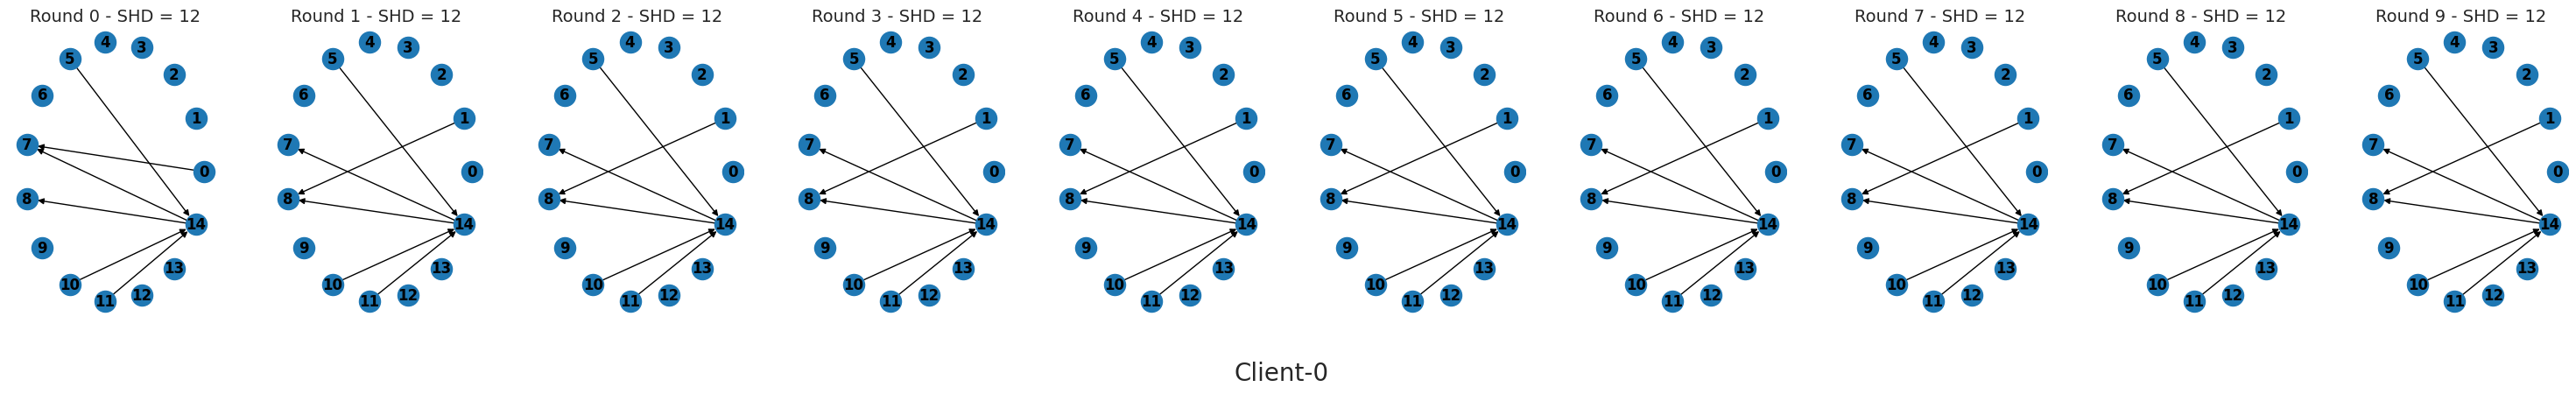

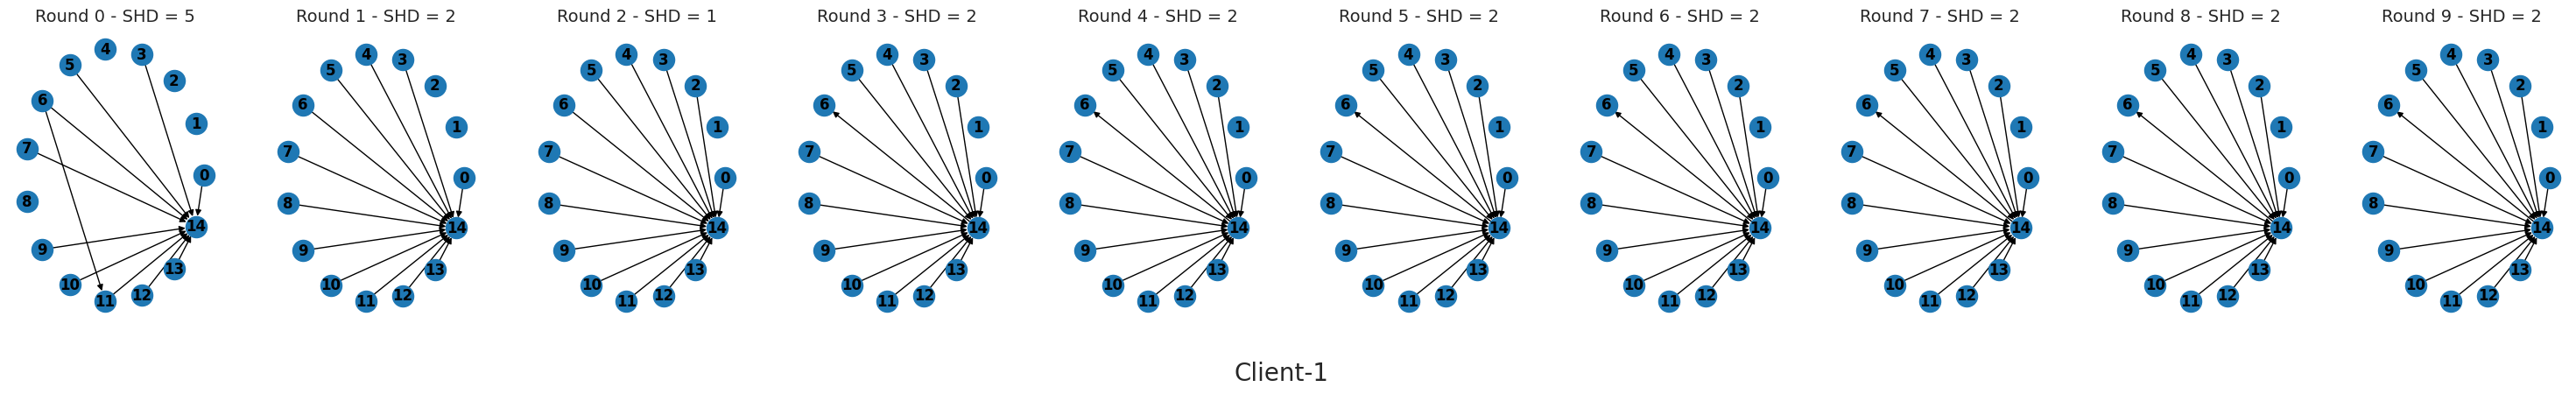

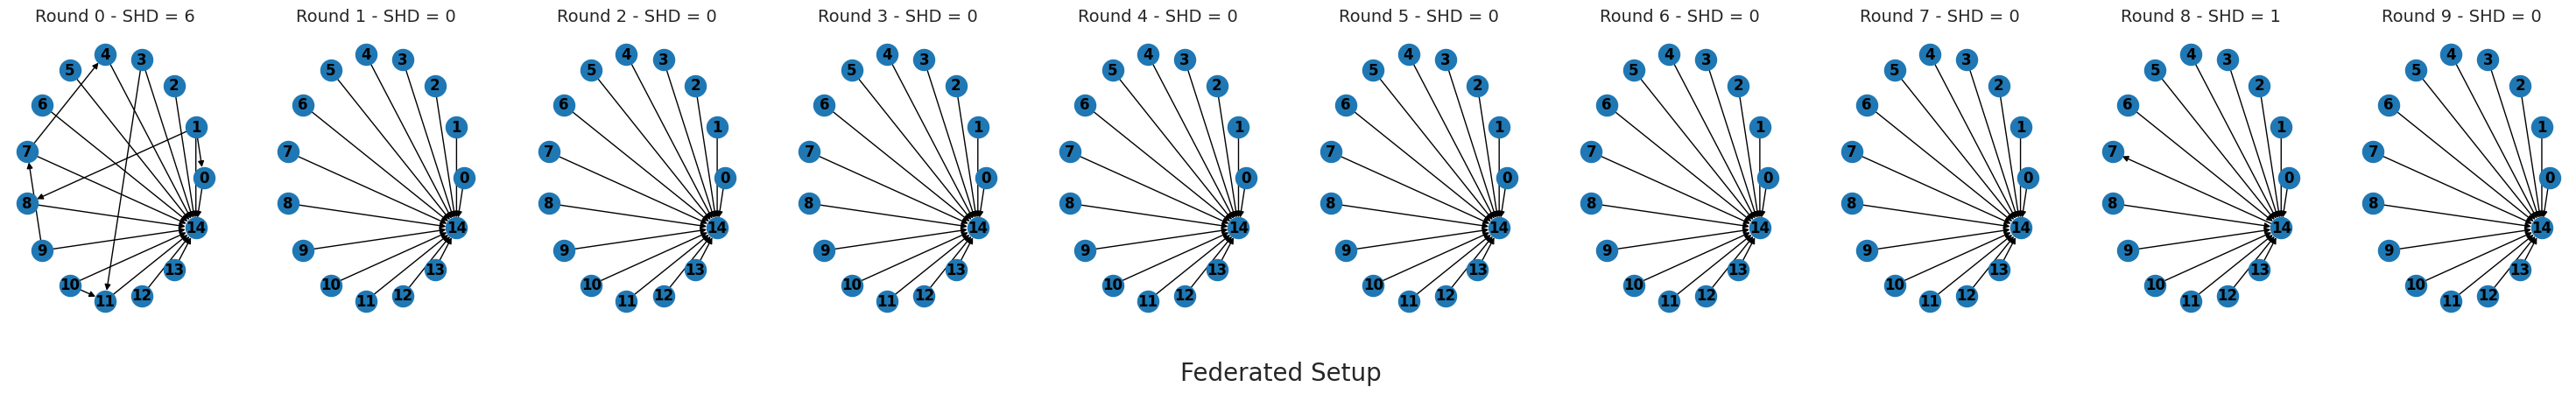

In [88]:
# Experiments
num_rounds = 10
rounds = np.arange(start=0, stop=num_of_rounds, step=1)
sns.set_style('darkgrid')


folder_name = "str_toy/unbl/ToySetup-collider-15"
setups = ["Client-0", "Client-1", "Federated Setup"]
n_row = len(setups)
n_col = num_rounds

fig, axs = plt.subplots(n_row, n_col, figsize=(30, 4), dpi=100)
fig.tight_layout(h_pad=2, w_pad=0.5)

for r, setup in enumerate(setups):
    data_file_name = f'results_{idx}_1.pickle'
    load_dir = os.path.join('data', folder_name, data_file_name)
    
    with open(load_dir, 'rb') as handle:
        results_dict = pickle.load(handle)

    setup_mats = retrieve_adj_mats_per_round(results_dict, rounds)
    client_id = 0 if setup != "Federated Setup" else 'priors'
    setup_shds = retrieve_client_info(results_dict, 'SHD', client_id)

    for c in range(n_col):
        graph = nx.DiGraph(setup_mats[c])
        nx.draw_circular(graph, ax=axs[c], with_labels=True, font_weight='bold')
        axs[r, c].set_title(f'Round {c} - SHD = {setup_shds[c]}', fontsize=14)
        axs[r, c].set_axis_off()

plt.show()
    
